# CICERO SCM notebook - parallel application

Import some stuff

In [1]:
import sys
import re
import os
import numpy as np
import shutil
import matplotlib.pyplot as plt
import pandas as pd
import pandas.testing as pdt
import warnings
import logging

try:
    from pandas.core.common import SettingWithCopyWarning
except:
    from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.filterwarnings("ignore", message=".*Parameter.*")

In [2]:
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm

In [3]:
import concurrent

In [4]:
from ciceroscm.parallel._configdistro import _ConfigDistro
from ciceroscm.parallel.calibrator import Calibrator
from ciceroscm.parallel.distributionrun import DistributionRun


/Users/sanderson/Documents/GitHub/ciceroscm/venv/lib/python3.12/site-packages/scmdata/database/_database.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdman


Import the model

In [5]:
sys.path.insert(0,os.path.join(os.getcwd(), '../', 'src'))
from ciceroscm import CICEROSCM

Define some input handling functions to give us example inputs

In [6]:
from ciceroscm.input_handler import read_inputfile,read_components,read_natural_emissions

Define a function to convert model output to a dataframe

set up input directories

In [7]:
test_data_dir = os.path.join(os.getcwd(), '../../', 'tests', 'test-data')

# Read in datafiles into dataframes

In [8]:
# NBVAL_IGNORE_OUTPUT
#Read gas parameters
gaspam =read_components(test_data_dir + '/gases_v1RCMIP.txt')
gaspam.head()

,EM_UNIT,CONC_UNIT,BETA,ALPHA,TAU1,TAU2,TAU3,NAT_EM,SARF_TO_ERF
GAS,,,,,,,,,
CO2,Pg_C,ppm,2.123,0.00000,150.00,0,0,0.0,1.000000
CH4,Tg,ppb,2.780,0.00000,9.60,120,160,275.0,0.877193
N2O,Tg_N,ppb,4.810,0.00000,121.00,0,0,9.5,1.000000
SO2,Tg_S,-,11.000,0.00000,0.02,0,0,0.0,1.000000
CFC-11,Gg,ppt,22.600,0.00026,45.00,0,0,0.0,1.000000


Read natural emissions

In [9]:
# NBVAL_IGNORE_OUTPUT
df_nat_ch4 =read_natural_emissions(test_data_dir + '/natemis_ch4.txt','CH4')
df_nat_n2o =read_natural_emissions(test_data_dir + '/natemis_n2o.txt','N2O')
df_nat_ch4.head()


,CH4
year,
1750,269.4273
1751,270.9068
1752,273.0183
1753,272.0470
1754,271.1915


Read forcing

In [10]:
df_ssp2_conc =read_inputfile(test_data_dir + '/ssp245_conc_RCMIP.txt')
df_ssp2_conc.head()

,CO2,CH4,N2O,CFC-11,CFC-12,CFC-113,CFC-114,CFC-115,CH3Br,CCl4,...,HFC143a,HFC227ea,HFC23,HFC245fa,HFC32,HFC4310mee,C2F6,C6F14,CF4,SF6
Component,,,,,,,,,,,,,,,,,,,,,
1700,276.746000,706.054021,272.212049,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0
1701,276.749995,706.247004,272.243047,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0
1702,276.757998,706.375031,272.266047,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0
1703,276.757001,706.491002,272.298047,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0
1704,276.755000,706.602046,272.331052,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0


In [11]:
emi_input =read_inputfile(test_data_dir + '/ssp245_em_RCMIP.txt')
emi_input.rename(columns={"CO2": "CO2_FF", "CO2.1": "CO2_AFOLU"}, inplace=True)
emi_input.head()

,CO2_FF,CO2_AFOLU,CH4,N2O,SO2,CFC-11,CFC-12,CFC-113,CFC-114,CFC-115,...,CF4,SF6,NOx,CO,NMVOC,NH3,BMB_AEROS_BC,BMB_AEROS_OC,BC,OC
Component,,,,,,,,,,,,,,,,,,,,,
1750,0.002592,0.081127,19.019783,0.054710,1.222464,0.0,0.0,0.0,0.0,0.0,...,0.010071,0.0,3.871504,348.527359,60.021826,6.927690,1.353250,12.520269,0.744520,2.927399
1751,0.002593,0.082619,18.915109,0.055744,1.206598,0.0,0.0,0.0,0.0,0.0,...,0.010071,0.0,3.828060,343.926367,59.088126,6.860142,1.335274,12.279280,0.737652,2.909437
1752,0.002594,0.084139,18.889712,0.056797,1.200955,0.0,0.0,0.0,0.0,0.0,...,0.010071,0.0,3.828658,341.809034,58.631997,6.819482,1.326617,12.121816,0.737695,2.912659
1753,0.002594,0.085687,19.121377,0.057870,1.207757,0.0,0.0,0.0,0.0,0.0,...,0.010071,0.0,3.812105,343.675456,59.026349,6.881439,1.328560,12.249330,0.743391,2.933215
1754,0.002595,0.087263,19.509061,0.058963,1.233495,0.0,0.0,0.0,0.0,0.0,...,0.010071,0.0,3.841598,349.815625,60.269945,7.015189,1.346553,12.593635,0.752796,2.965138


# Set up model run with defined input variables

In [12]:
scendata={
            "gaspam_data": gaspam,
            "emstart": 1750,  
            "conc_run":False,
            "nystart": 1750,
            "nyend": 2100,
            "concentrations_data": df_ssp2_conc,
            "emissions_data": emi_input,
            "nat_ch4_data": df_nat_ch4,
            "nat_n2o_data": df_nat_n2o,
            "idtm":24,
            "udir": test_data_dir,
            "scenname": "ssp245",
        }

In [13]:
    calibdata = pd.DataFrame(
        data={
            "Variable Name": [
                "Heat Content|Ocean",
                "Surface Air Ocean Blended Temperature Change",
            ],
            "Yearstart_norm": [1971, 1961],
            "Yearend_norm": [1971, 1990],
            "Yearstart_change": [2018, 2000],
            "Yearend_change": [2018, 2019],
            "Central Value": [320.69251537323, 0.5372],
            "sigma": [17.020342912051203, 0.039028311931729676],
        })

In [14]:
ordering=[
    "rlamdo",
    "akapa",
    "cpi",
    "W",
    "beto",
    "lambda",
    "mixed",
    "qo3",
    "qdirso2",
    "qindso2",
    "qbc",
    "qoc",
    "beta_f",
    "mixed_carbon",
    "qbmb",
    "qh2o_ch4",
]

In [15]:
len(ordering)

16

In [16]:
prior_flat_array = np.array(
    [
        [5, 25],
        [0.06, 0.8],
        [0.161, 0.569],
        [0.55, 2.55],
        [0, 7],
        [2 / 3.71, 5 / 3.71],
        [25, 125],
        [0.4, 0.6],
        [-0.55, -0.2],
        [-1.5, -0.5],
        [0.1, 0.2],
        [-0.1, -0.06],
        [0.110, 0.465],
        [25, 125],
        [0, 2],
        [0.08, 0.1],
    ]
)

In [17]:
prior_flat_array.shape

(16, 2)

In [18]:
    testconfig = _ConfigDistro(
        distro_array=prior_flat_array,
        setvalues={
            "threstemp": 7.0,
            "lm": 40,
            "ldtime": 12,
        },
        ordering=ordering,
    )

16

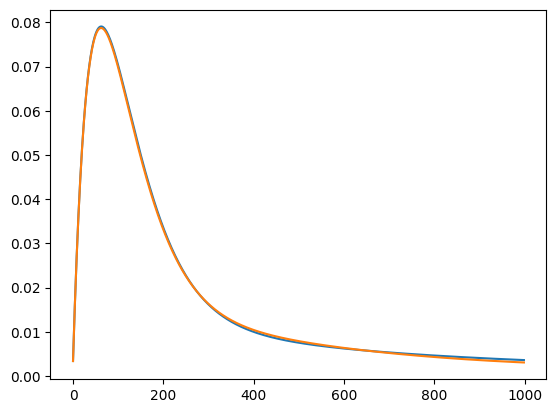

In [19]:
len(testconfig.ordering)

In [20]:
# NBVAL_IGNORE_OUTPUT
scen = 'test'
cscm_dir=CICEROSCM({
            "gaspam_data": gaspam,
            "emstart": 1750,  
            "conc_run":False,
            "nystart": 1750,
            "nyend": 2100,
            "concentrations_data": df_ssp2_conc,
            "emissions_data": emi_input,
            "nat_ch4_data": df_nat_ch4,
            "nat_n2o_data": df_nat_n2o,
            "idtm":24
        })

In [21]:
distrorun1 = DistributionRun(testconfig, numvalues=50000)
output_vars = ["Heat Uptake", "Surface Air Temperature Change"]


[ 5.          0.06        0.161       0.55        0.          0.53908356
 25.          0.4        -0.55       -1.5         0.1        -0.1
  0.11       25.          0.          0.08      ]
[ 2.50000000e+01  8.00000000e-01  5.69000000e-01  2.55000000e+00
  7.00000000e+00  1.34770889e+00  1.25000000e+02  6.00000000e-01
 -2.00000000e-01 -5.00000000e-01  2.00000000e-01 -6.00000000e-02
  4.65000000e-01  1.25000000e+02  2.00000000e+00  1.00000000e-01]


In [22]:
def get_results(cfg):
    try:
        cscm_dir._run({"results_as_dict": True},pamset_udm=cfg['pamset_udm'],pamset_emiconc=cfg['pamset_emiconc'])
        res=cscm_dir.results

    except:
        res=None
    return [cfg,res]

In [23]:
def run_parallel(cfgs,nworkers=4):
    results=len(cfgs)*[None]
    with ProcessPoolExecutor(nworkers) as exe:
            # execute tasks concurrently and process results in order
            pres=list(tqdm(exe.map(get_results, cfgs)))
            for result in pres:
                # get the corresponding index of the config
                ind=int(result[0]['Index'])
                # put it in the right element of the results vector
                results[ind]=result[1]
    return results

In [24]:
results=run_parallel(distrorun1.cfgs,nworkers=200)

50000it [17:23, 47.92it/s] 


In [25]:
flds=['dT_glob','OHC700','concentrations-CO2','RIB_glob']

In [26]:
isgd=np.where([r!=None for r in results])[0].astype(int)

In [27]:
fresults = [results[i] for i in isgd]
fcfgs=[distrorun1.cfgs[i] for i in isgd]

In [28]:
def to_df(rs):

    out=pd.concat([pd.DataFrame(v).reset_index(drop=True) for k, v in rs.items()], keys = rs.keys(),axis=1) 
    out.index=rs['forcing'].index
    return out

In [29]:
def make_ensdf(results,flds):
    resdf=[]
    for i,res in enumerate(results):
        df=to_df(res)
        test_list=df.columns.map('{0[0]}-{0[1]}'.format).tolist()
        df.columns=[sub.replace('-0', '') for sub in test_list]
        resdf.append(df[flds].unstack())
    ensdf=pd.concat(resdf,axis=1)
    return ensdf

In [30]:
df=make_ensdf(fresults,flds)

In [31]:
issane=np.where(df.max()<1e8)[0]

In [32]:
df

0         1         2         3         4         5      \
dT_glob  1750  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
         1751 -0.004254 -0.006264 -0.001179 -0.002318 -0.002349 -0.006363   
         1752 -0.013857 -0.024557 -0.004587 -0.009539 -0.010317 -0.021946   
         1753 -0.020130 -0.038411 -0.007287 -0.016281 -0.018297 -0.032518   
         1754 -0.016444 -0.032120 -0.006221 -0.015849 -0.018387 -0.026290   
...                 ...       ...       ...       ...       ...       ...   
RIB_glob 2096  0.697980  0.286011  0.702010  0.503026  0.389458  0.039457   
         2097  0.678554  0.265603  0.688629  0.488219  0.377092  0.019267   
         2098  0.659267  0.245296  0.675339  0.473488  0.364847 -0.000793   
         2099  0.640090  0.225063  0.662113  0.458810  0.352694 -0.020748   
         2100  0.621006  0.204891  0.648934  0.444171  0.340612 -0.040612   

                  6         7         8         9      ...     49990  \
dT_glob  1750  0.000000  0.000000  0.000000  0.000000  ...  0.000000   
         1751 -0.001275 -0.003847 -0.002399 -0.001857  ... -0.004112   
         1752 -0.005103 -0.014495 -0.008871 -0.007824  ... -0.014373   
         1753 -0.008536 -0.022401 -0.014132 -0.013142  ... -0.021452   
         1754 -0.008073 -0.018620 -0.012755 -0.012124  ... -0.017283   
...                 ...       ...       ...       ...  ...       ...   
RIB_glob 2096  1.116657  0.835219  0.298499  0.839595  ...  0.695266   
         2097  1.099213  0.818203  0.285030  0.823092  ...  0.679569   
         2098  1.081812  0.801240  0.271733  0.806645  ...  0.663955   
         2099  1.064431  0.784307  0.258577  0.790229  ...  0.648400   
         2100  1.047055  0.767388  0.245539  0.773832  ...  0.632888   

                  49991     49992     49993     49994     49995     49996  \
dT_glob  1750  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
         1751 -0.008773 -0.004200 -0.004359 -0.005581 -0.001607 -0.000037   
         1752 -0.029723 -0.013885 -0.017474 -0.022498 -0.006503 -0.000072   
         1753 -0.043651 -0.019892 -0.029179 -0.035502 -0.010891  0.000227   
         1754 -0.034998 -0.015267 -0.027696 -0.029664 -0.010133  0.001125   
...                 ...       ...       ...       ...       ...       ...   
RIB_glob 2096  0.101327  0.575046  0.611384  0.333008  0.234005  0.737896   
         2097  0.081487  0.558311  0.589475  0.315727  0.226264  0.729322   
         2098  0.061787  0.541707  0.567662  0.298566  0.218635  0.720813   
         2099  0.042197  0.525203  0.545917  0.281498  0.211084  0.712339   
         2100  0.022701  0.508782  0.524225  0.264505  0.203592  0.703888   

                  49997     49998     49999  
dT_glob  1750  0.000000  0.000000  0.000000  
         1751 -0.000077 -0.007921 -0.001486  
         1752 -0.000249 -0.030246 -0.004832  
         1753 -0.000233 -0.046767 -0.006542  
         1754  0.000229 -0.038639 -0.004157  
...                 ...       ...       ...  
RIB_glob 2096  1.017681  0.450099  0.694023  
         2097  1.005675  0.426964  0.682398  
         2098  0.993749  0.403928  0.670853  
         2099  0.981875  0.380966  0.659361  
         2100  0.970035  0.358060  0.647908  

[1404 rows x 50000 columns]

In [33]:
df1 = df.iloc[:,issane]
fcfgs1=[fcfgs[i] for i in issane]

In [34]:
df1.index.names = ['variable', 'year']
df1.columns.names=['run_id']

In [35]:
def plot_range(df, var, ax,col='k'):
    Tdf=df.xs(var).T
    lower = Tdf.quantile(0.10)
    upper = Tdf.quantile(0.90)
    ax.fill_between(Tdf.columns, lower, upper, color=col, alpha=0.2,edgecolor=None)
    ax.plot(Tdf.columns, Tdf.mean(), color=col)



(0.0, 5.0)

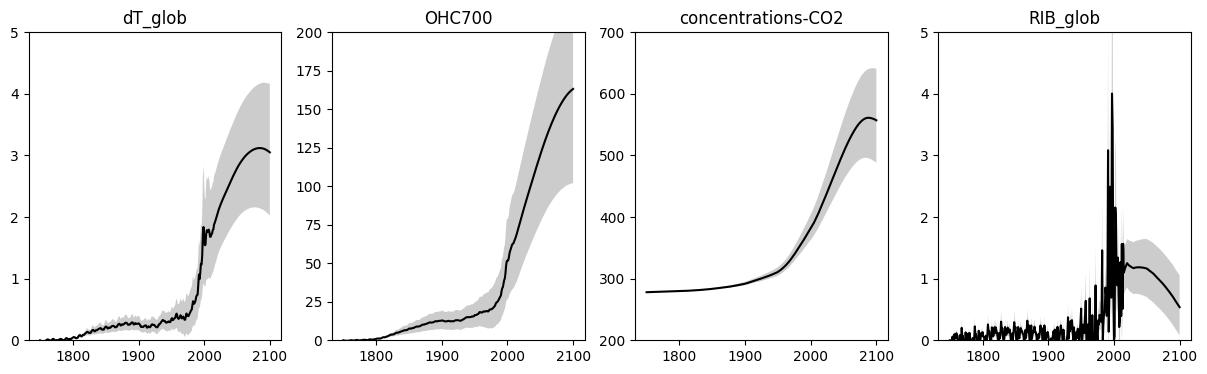

In [36]:
fig, ax = plt.subplots( 1,len(flds) ,figsize=(15, 4))

ax=ax.flatten()
for i,f in enumerate(flds):
    plot_range(df1, f, ax[i])
    ax[i].set_title(f)
ax[0].set_ylim([0,5])
ax[1].set_ylim([0,200])
ax[2].set_ylim([200,700])
ax[3].set_ylim([0,5])



In [37]:
dates=[1955,1975,1995,2008,2018]
targ=df1.loc[(slice(None), dates), :].T
nflds=targ.shape[1]


In [38]:
targ['OHC700']=(targ['OHC700'].T-targ['OHC700'][1995]).T

In [39]:
targ['OHC700']

year,1955,1975,1995,2008,2018
run_id,,,,,
0,-15.429156,-16.367508,0.0,25.082364,39.486546
1,-32.261924,-25.636342,0.0,32.492104,45.252528
2,-17.392101,-14.935293,0.0,16.522850,27.489917
3,-35.519354,-25.598490,0.0,25.366480,38.182164
4,-18.689985,-15.840382,0.0,17.032252,26.938775
...,...,...,...,...,...
49995,-14.243833,-11.634994,0.0,10.273433,17.177230
49996,-8.195181,-8.483678,0.0,9.241265,18.377475
49997,-13.688942,-12.674081,0.0,14.138469,27.272235


In [40]:
def merge_dicts(dc):
    x=dc['pamset_udm']
    y=dc['pamset_emiconc']
    z = x.copy()
    z.update(y)
    return z

In [41]:
pdict=fcfgs1
mdict=[ merge_dicts(d) for d in pdict ]
pmat=pd.DataFrame(mdict)

In [42]:
parammat=pmat.loc[:, (pmat != pmat.iloc[0]).any()]
parammat

,rlamdo,akapa,cpi,W,beto,lambda,mixed,qo3,qdirso2,qindso2,qbc,qoc,beta_f,mixed_carbon,qbmb,qh2o_ch4
0,5.475075,0.145985,0.267757,0.692967,2.846540,1.277469,123.758613,0.512378,-0.422852,-1.352024,0.148553,-0.064902,0.289437,64.719731,0.853496,0.096314
1,17.144449,0.783401,0.228853,0.912634,1.420276,0.877237,51.587577,0.493052,-0.302201,-0.781460,0.136955,-0.098338,0.417027,94.994594,1.552293,0.086882
2,18.160192,0.710225,0.453996,2.393496,6.492984,0.683369,92.342138,0.572524,-0.233373,-0.968027,0.141893,-0.089233,0.356836,98.086940,0.418123,0.087738
3,21.800690,0.368766,0.387707,1.365818,5.871009,0.741653,114.307032,0.593215,-0.237266,-0.504527,0.152572,-0.085855,0.240731,60.870767,0.910365,0.084272
4,19.742370,0.161939,0.378009,1.163513,2.335806,1.027577,70.816075,0.437867,-0.538627,-0.614570,0.175846,-0.099671,0.255616,116.254343,0.643882,0.091023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,13.447217,0.109055,0.203084,0.670359,1.532166,0.607710,77.068905,0.581348,-0.462473,-0.667627,0.166713,-0.085053,0.214002,93.920303,0.456552,0.095709
49996,19.653465,0.191315,0.349293,2.512368,0.121058,0.892526,37.728663,0.588098,-0.238661,-1.374187,0.165229,-0.096993,0.355653,44.716456,0.022416,0.089559
49997,15.210023,0.503741,0.351625,1.178407,6.248044,0.718844,95.373448,0.500785,-0.217900,-1.190984,0.130445,-0.094770,0.356844,36.374873,0.040614,0.095241
49998,11.480125,0.612875,0.388815,1.928752,4.213097,1.133298,48.741971,0.433102,-0.329288,-1.369153,0.132456,-0.099870,0.313997,93.624326,1.626755,0.085950


In [43]:
store = pd.HDFStore('data/data.h5')
store['targ'] = targ
store['parammat'] = parammat
store.close()